In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import tensorflow as tf

2023-05-03 14:44:45.762589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"

In [3]:
def process_ts_lsq_results(result_dir: str,
                           num_runs: int,
                           failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [4]:
def process_ts_gsbp_results(result_dir: str,
                            num_runs: int,
                            failure_val: float,
                            equality_tolerance: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= equality_tolerance
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= equality_tolerance
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [5]:
def process_original_albo_lsq_results(result_dir: str,
                                      num_runs: int,
                                      failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [6]:
def process_original_albo_gsbp_results(result_dir: str,
                                       num_runs: int,
                                       failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

### LSQ

In [60]:
ts_al_adam_lsq_results, ts_al_adam_lsq_results_mean, ts_al_adam_lsq_results_median, ts_al_adam_lsq_results_std = process_ts_lsq_results("../results/final_ts_results/lsq/adam/data/", 100, 1.7)
ts_al_bfgs_lsq_results, ts_al_bfgs_lsq_results_mean, ts_al_bfgs_lsq_results_median, ts_al_bfgs_lsq_results_std = process_ts_lsq_results("../results/final_ts_results/lsq/l_bfgs_b/data/", 100, 1.7)
original_albo_lsq_results, original_albo_lsq_results_mean, original_albo_lsq_results_median, original_albo_lsq_results_std = process_original_albo_lsq_results("../results/final_original_results/lsq/slack_optim/data/", 100, 1.4)
random_lsq_results, random_lsq_results_mean, random_lsq_results_median, random_lsq_results_std = process_ts_lsq_results("../results/11-04-23/lsq_random/", 100, 1.4)
consistent_results, consistent_results_mean, consistent_results_median, consistent_results_std = process_ts_lsq_results("../results/14-04-23/lsq_fully_consistent/data/", 100, 1.4)

In [8]:
ts_al_adam_lsq_results.shape

(100, 45)

In [9]:
original_albo_lsq_results.shape

(100, 45)

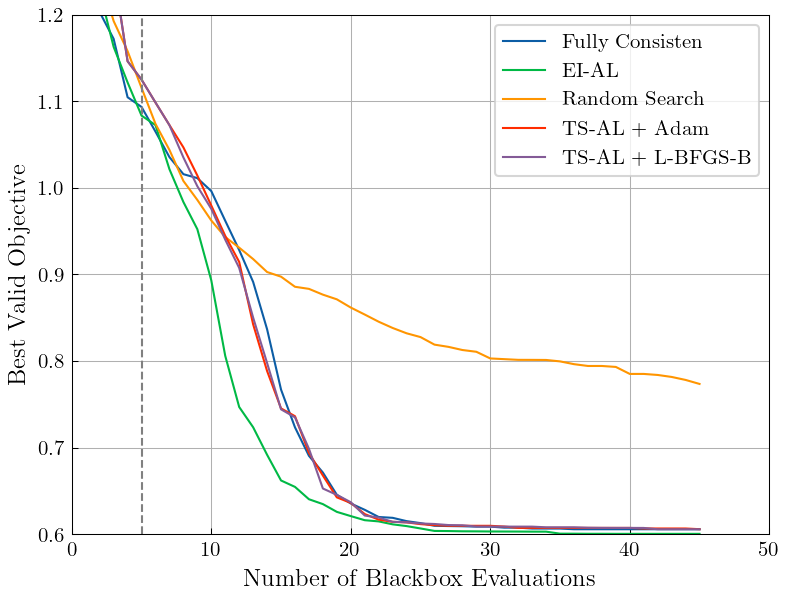

In [61]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(6, 4.5))
iters = [i for i in range(1, 46)]
# plt.plot(iters, ts_al_kkt_lsq_results_mean[:50], label="TS-AL Gradient Update")
# plt.plot(iters, ts_al_original_lsq_results_mean[:50], label="TS-AL Original Update")
plt.plot(iters, consistent_results_mean[:45], label="Fully Consisten")
plt.plot(iters, original_albo_lsq_results_mean, label="EI-AL")
plt.plot(iters, random_lsq_results_mean[:45], label="Random Search")
plt.plot(iters, ts_al_adam_lsq_results_mean, label="TS-AL + Adam")
plt.plot(iters, ts_al_bfgs_lsq_results_mean, label="TS-AL + L-BFGS-B")
plt.axvline(x=5, color='grey', linestyle='--')
# plt.fill_between(iters, original_albo_lsq_results_mean[:45]+original_albo_lsq_results_std[:45], original_albo_lsq_results_mean[:50]-original_albo_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, random_lsq_results_mean[:50]+random_lsq_results_std[:50], random_lsq_results_mean[:50]-random_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 50)
plt.ylim(0.6, 1.2)
plt.show()

### GSBP

In [7]:
ts_al_adam_aggressive_gsbp_results, ts_al_adam_aggressive_gsbp_results_mean, ts_al_adam_aggressive_gsbp_results_median, ts_al_adam_aggressive_gsbp_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_aggressive/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_conservative_gsbp_results, ts_al_adam_conservative_gsbp_results_mean, ts_al_adam_conservative_gsbp_results_median, ts_al_adam_conservative_gsbp_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_conservative/data/", 50, 2.1, equality_tolerance=0.01)
original_albo_aggressive_gsbp_results, original_albo_aggressive_gsbp_results_mean, original_albo_aggressive_gsbp_results_median, original_albo_aggressive_gsbp_results_std = process_original_albo_gsbp_results("../results/final_original_results/gsbp/slack_optim_aggressive/data/", 50, 2.1)
original_albo_conservative_gsbp_results, original_albo_conservative_gsbp_results_mean, original_albo_conservative_gsbp_results_median, original_albo_conservative_gsbp_results_std = process_original_albo_gsbp_results("../results/final_original_results/gsbp/slack_optim_conservative/data/", 50, 2.1)
random_gsbp_results, random_gsbp_results_mean, random_gsbp_results_median, random_gsbp_results_std = process_ts_gsbp_results("../results/11-04-23/gsbp_random/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_aggressive_results, ts_al_adam_no_prev_aggressive_results_mean, ts_al_adam_no_prev_aggressive_results_median, ts_al_adam_no_prev_aggressive_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_aggressive/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_conservative_results, ts_al_adam_no_prev_conservative_results_mean, ts_al_adam_no_prev_conservative_results_median, ts_al_adam_no_prev_conservative_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_conservative/data/", 50, 2.1, equality_tolerance=0.01)

2023-05-03 14:44:54.609302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
print(ts_al_adam_no_prev_aggressive_results[1, :])

[ 2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         0.32538759  0.32538759 -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.

In [28]:
print(np.mean(ts_al_adam_aggressive_gsbp_results[:, :], axis=0))

[ 2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.0474521   2.0474521   2.0474521   1.95942693  1.69668742
  1.59159161  1.48720239  1.32885191  1.13652541  0.96139594  0.90801459
  0.87202338  0.69489918  0.53647995  0.3442249   0.32525573  0.28933698
  0.28933698  0.23664594  0.23664594  0.23664594  0.18409804  0.13155014
  0.13155014  0.13155014  0.13155014  0.13155014  0.13155014  0.09554395
  0.09554395  0.09554395  0.09554395  0.09554395  0.09554395  0.09554395
  0.09554395  0.09554395  0.09554395  0.09554395  0.06015543  0.06004505
  0.06004505  0.06004505  0.06004505  0.02407492  0.02407492  0.02407492
  0.0070533   0.0070533   0.0070533   0.0070533   0.0070533   0.0070533
  0.0070533   0.0070533   0.0070533  -0.0286781  -0.0286781  -0.04563796
 -0.04563796 -0.08206092 -0.13460882 -0.13460882 -0.13460882 -0.13460882
 -0.13460882 -0.13460882 -0.13460882 -0.13460882 -0.13460882 -0.13

In [30]:
print(ts_al_adam_aggressive_gsbp_results_mean)

[ 2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.0474521   2.0474521   2.0474521   1.95942693  1.69668742
  1.59159161  1.48720239  1.32885191  1.13652541  0.96139594  0.90801459
  0.87202338  0.69489918  0.53647995  0.3442249   0.32525573  0.28933698
  0.28933698  0.23664594  0.23664594  0.23664594  0.18409804  0.13155014
  0.13155014  0.13155014  0.13155014  0.13155014  0.13155014  0.09554395
  0.09554395  0.09554395  0.09554395  0.09554395  0.09554395  0.09554395
  0.09554395  0.09554395  0.09554395  0.09554395  0.06015543  0.06004505
  0.06004505  0.06004505  0.06004505  0.02407492  0.02407492  0.02407492
  0.0070533   0.0070533   0.0070533   0.0070533   0.0070533   0.0070533
  0.0070533   0.0070533   0.0070533  -0.0286781  -0.0286781  -0.04563796
 -0.04563796 -0.08206092 -0.13460882 -0.13460882 -0.13460882 -0.13460882
 -0.13460882 -0.13460882 -0.13460882 -0.13460882 -0.13460882 -0.13

In [27]:
print(ts_al_adam_no_prev_aggressive_results_mean)

[ 2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.03431512  1.96863024  1.70734217
  1.64165729  1.51117077  1.33414379  1.18129494  1.00669737  0.94000694
  0.8504668   0.56381373  0.45448589  0.32257506  0.25628697  0.146785
  0.12607664  0.10516313  0.10516313  0.10516313  0.03839692 -0.04839722
 -0.04867305 -0.04867305 -0.04867305 -0.06995389 -0.06995389 -0.13622593
 -0.13622593 -0.13622593 -0.13622593 -0.13622593 -0.13622593 -0.13622593
 -0.13622593 -0.13622593 -0.13622593 -0.20191081 -0.20191081 -0.22292874
 -0.22292874 -0.22292874 -0.22292874 -0.22292874 -0.22292874 -0.24359798
 -0.24359798 -0.24359798 -0.24359798 -0.24359798 -0.24359798 -0.24359798
 -0.24359798 -0.24359798 -0.30928286 -0.30928286 -0.30928286 -0.35365536
 -0.35365536 -0.3991872  -0.3991872  -0.3991872  -0.3991872  -0.3991872
 -0.3991872  -0.41934024 -0.41934024 -0.41934024 -0.44039784 -0.4403

In [39]:
a = [-0.5273951 for _ in range(24)]

In [42]:
a += [2.1]

In [44]:
np.mean(a)

-0.422299296

In [16]:
print(ts_al_adam_no_prev_aggressive_results[:20, 140])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951]


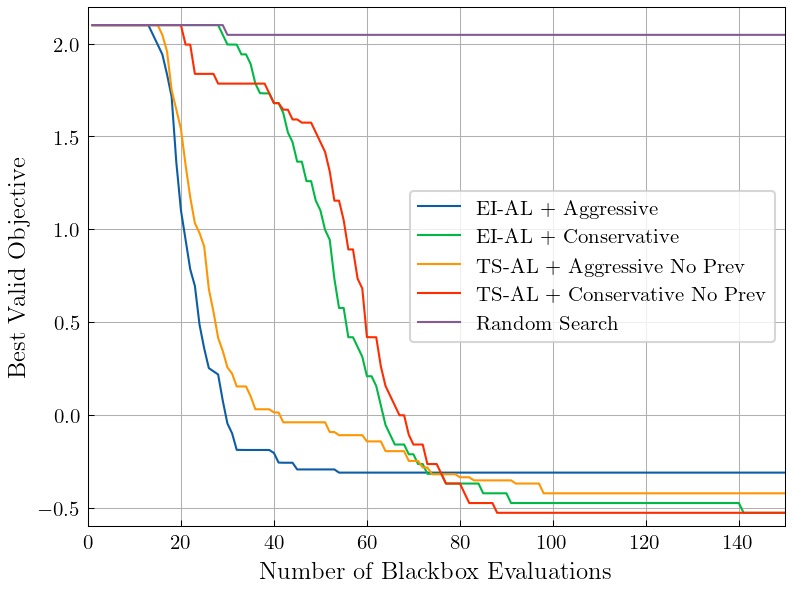

In [74]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(6, 4.5))
iters = [i for i in range(1, 151)]
plt.plot(iters, original_albo_aggressive_gsbp_results_mean, label="EI-AL + Aggressive")
plt.plot(iters, original_albo_conservative_gsbp_results_mean, label="EI-AL + Conservative")
# plt.plot(iters, ts_al_adam_aggressive_gsbp_results_mean, label="TS-AL + Aggressive")
# plt.plot(iters, ts_al_adam_conservative_gsbp_results_mean, label="TS-AL + Conservative")
plt.plot(iters, ts_al_adam_no_prev_aggressive_results_mean, label="TS-AL + Aggressive No Prev")
plt.plot(iters, ts_al_adam_no_prev_conservative_results_mean, label="TS-AL + Conservative No Prev")
plt.plot(iters, random_gsbp_results_mean, label="Random Search")
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 150)
plt.ylim(-0.6, 2.2)
plt.show()

In [67]:
def fraction_of_runs_found_feasible_point(all_runs: np.array,
                                          num_runs: int,
                                          failure_val: float):
    assert(all_runs.shape[0] == num_runs)
    found_feasible_point = np.where(all_runs == failure_val, 0, 1)
    feasible_fraction = np.sum(found_feasible_point, axis=0)/num_runs
    return feasible_fraction

In [69]:
feasible_fraction_adam_aggressive = fraction_of_runs_found_feasible_point(ts_al_adam_aggressive_gsbp_results, 50, 2.1)
feasible_fraction_adam_conservative = fraction_of_runs_found_feasible_point(ts_al_adam_conservative_gsbp_results, 50, 2.1)
feasible_fraction_random = fraction_of_runs_found_feasible_point(random_gsbp_results, 50, 2.1)
feasible_fraction_original_albo_aggressive = fraction_of_runs_found_feasible_point(original_albo_aggressive_gsbp_results, 50, 2.1)
feasible_fraction_original_albo_conservative = fraction_of_runs_found_feasible_point(original_albo_conservative_gsbp_results, 50, 2.1)
feasible_fraction_adam_no_prev_aggressive = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_aggressive_results, 50, 2.1)
feasible_fraction_adam_no_prev_conservative = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_conservative_results, 50, 2.1)

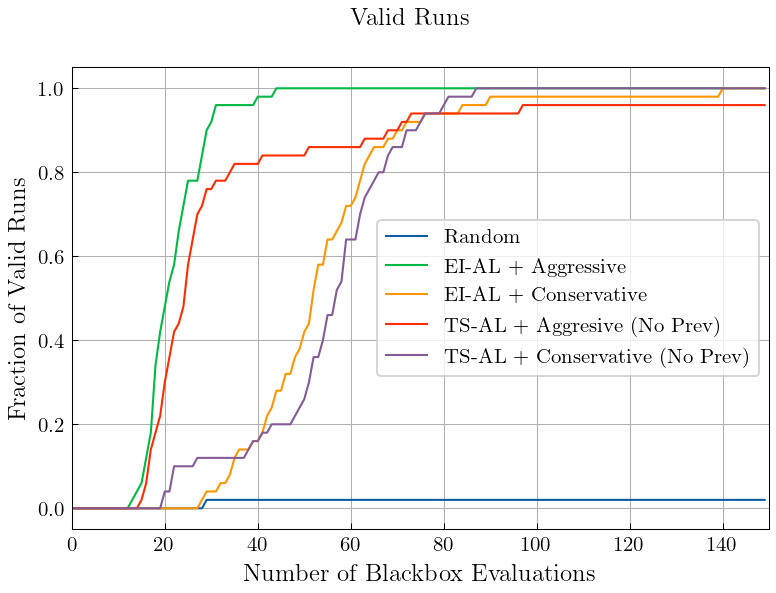

In [75]:
plt.figure(figsize=(6,4))
plt.plot(feasible_fraction_random, label="Random")
plt.plot(feasible_fraction_original_albo_aggressive, label="EI-AL + Aggressive")
plt.plot(feasible_fraction_original_albo_conservative, label="EI-AL + Conservative")
# plt.plot(feasible_fraction_adam_aggressive, label="TS-AL + Aggressive")
# plt.plot(feasible_fraction_adam_conservative, label="TS-AL + Conservative")
plt.plot(feasible_fraction_adam_no_prev_aggressive, label="TS-AL + Aggresive (No Prev)")
plt.plot(feasible_fraction_adam_no_prev_conservative, label="TS-AL + Conservative (No Prev)")
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Fraction of Valid Runs')
plt.suptitle("Valid Runs")
plt.legend()
plt.xlim(0, 150)
plt.legend()

In [71]:
def fraction_of_runs_found_optimal_point(all_runs: np.array,
                                         num_runs: int,
                                         optimal_val: float):
    assert(all_runs.shape[0] == num_runs)
    found_optimal_point = np.where(all_runs == optimal_val, 1, 0)
    optimal_fraction = np.sum(found_optimal_point, axis=0)/num_runs
    return optimal_fraction

In [72]:
optimal_fraction_adam_aggressive = fraction_of_runs_found_optimal_point(ts_al_adam_aggressive_gsbp_results, 50, -0.5273951)
optimal_fraction_adam_conservative = fraction_of_runs_found_optimal_point(ts_al_adam_conservative_gsbp_results, 50, -0.5273951)
optimal_fraction_random = fraction_of_runs_found_optimal_point(random_gsbp_results, 50, -0.5273951)
optimal_fraction_original_albo_aggressive = fraction_of_runs_found_optimal_point(original_albo_aggressive_gsbp_results, 50, -0.5273951)
optimal_fraction_original_albo_conservative = fraction_of_runs_found_optimal_point(original_albo_conservative_gsbp_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_aggressive = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_aggressive_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_conservative = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_conservative_results, 50, -0.5273951)

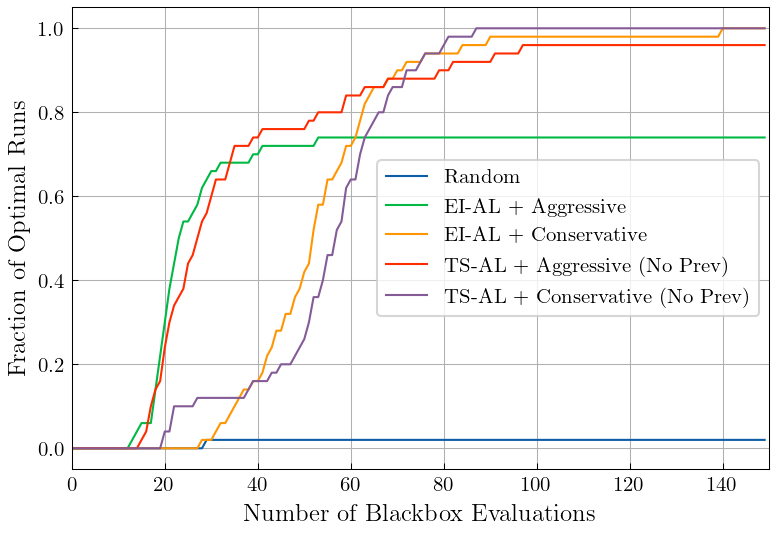

In [76]:
plt.figure(figsize=(6,4))
plt.plot(optimal_fraction_random, label="Random")
plt.plot(optimal_fraction_original_albo_aggressive, label="EI-AL + Aggressive")
plt.plot(optimal_fraction_original_albo_conservative, label="EI-AL + Conservative")
# plt.plot(optimal_fraction_adam_aggressive, label="TS-AL + Aggressive")
# plt.plot(optimal_fraction_adam_conservative, label="TS-AL + Conservative")
plt.plot(optimal_fraction_adam_no_prev_aggressive, label="TS-AL + Aggressive (No Prev)")
plt.plot(optimal_fraction_adam_no_prev_conservative, label="TS-AL + Conservative (No Prev)")
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Fraction of Optimal Runs')
plt.legend()
plt.xlim(0, 150)
plt.legend()